In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches
import wqchartpy
import datetime
import olm

print("Package versions: ")
print("Matplotlib: ",matplotlib.__version__)
print("NumPy: ", np.__version__)
print("Pandas: ",pd.__version__)
print("WQChartPy: 0.1.10")
#print("datetime
print("olm: 0.39")


Package versions: 
Matplotlib:  3.8.0
NumPy:  1.25.2
Pandas:  1.5.3
WQChartPy: 0.1.10
olm: 0.39


# Part 1: Dataset Formatting

### 1a. Read in the MasterWaterQuality.CSV file containing all the data from a weekly samplign field campaign form 2021-2022


Note that this file contains data not used in this analysis. We will only be using the data from Lake Jackson (labeled as "Porter Sink" here), the FSU Well, and Wakulla Springs.

In [2]:
wq_df = pd.read_csv('../data/raw_data/MasterWaterQuality.csv', parse_dates=['Sampling time'],
                    index_col='Sampling time')
wq_df

,ID,Location,dD vs vsmow,d18O vs vsmow,Lithium,Sodium,Ammonium,Potassium,Magnesium,Calcium,...,Bromide,Nitrate,Phosphate,Sulfate,pH,pOH,Total Alkalinity (mg/L as CaCO3),Bicarbonate,EC(us/cm),color
Sampling time,,,,,,,,,,,,,,,,,,,,,
2021-05-04 13:00:00,LJ000,Porter Sink,15.0,3.48,0.0,2.440,0.0,1.077,1.812,3.560,...,0.0,0.1223,0.0,0.0,6.52,7.48,13.8,16.836,52.1,k
2021-06-07 13:49:00,LJ001,Porter Sink,25.9,6.29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.11,8.89,2.8,3.416,44.5,k
2021-06-08 13:08:00,LJ002,Porter Sink,23.3,5.29,0.0,1.818,0.0,0.949,0.966,2.393,...,0.0,0.2130,0.0,0.0,6.55,7.45,6.0,7.320,32.0,k
2021-06-14 17:20:00,LJ003,Porter Sink,29.4,6.43,0.0,2.275,0.0,0.733,1.023,2.460,...,0.0,0.1929,0.0,0.0,5.99,8.01,7.2,8.784,35.0,k
2021-06-21 11:18:00,LJ004,Porter Sink,5.1,3.20,0.0,2.439,0.0,0.778,1.197,2.656,...,0.0,0.0000,0.0,0.0,6.31,7.69,9.8,11.956,38.0,k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 13:50:00,PRE001,Rain,-26.6,-4.25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
2021-07-05 15:39:00,PRE002,Rain,-50.6,-7.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
2021-07-18 13:15:00,PRE003,Rain,-5.8,-2.93,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.2019,0.0,0.0,NaN,NaN,NaN,NaN,NaN,y


### 1b. Use the OLM package from the Covington Lab of University of Arkansas to calculate a more accurate Bicarbonate using the Alkalinity value output from our titrator

In [3]:
###Accurate Bicarbonate Calculation OLM Package and USGS procedure
## ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
from olm.calcite import calc_K_2

#Function to convert Alkalinity as mg/L CaCO3 to meq/L
def alk_mgLCaCo3_to_meqL(alk_mgL):
    alk_meqL=alk_mgL/(1/2)/(100.087)
    return alk_meqL

## Second dissociation constant needed for speciation
K2=calc_K_2(298.15)

# ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
## The calculations mostly use meq/l but they are reconverted to mg/L as an output to keep units consistent in the dataframe

wq_df['H']=((10**-wq_df['pH'])*1.00784*1000).round(4)
wq_df["OH"]=((1E-14*(10**wq_df["pH"])*17007.3)).round(4)
wq_df["CO3"]=((((alk_mgLCaCo3_to_meqL(wq_df["Total Alkalinity (mg/L as CaCO3)"])/1000)-(wq_df['OH']/17007.3)+10**-wq_df['pH'])/(2+(10**-wq_df['pH']/K2)))*60009.2).round(4)

wq_df["HCO3"]=((((alk_mgLCaCo3_to_meqL(wq_df["Total Alkalinity (mg/L as CaCO3)"])/1000)-(wq_df['OH']/17007.3)+10**-wq_df['pH'])/(1+(2*K2*10**wq_df['pH'])))*61017.1).round(4)



### 1c. Make a copy of the full data set that is formatted in mg/L and presents only the sites used in this study

In [4]:
format_df = pd.DataFrame()

format_df['ID'] = wq_df['ID']
format_df['Sampling time'] = wq_df.index
format_df['Location']=wq_df['Location']

#PhysioChemistry
format_df['pH'] = wq_df['pH']
format_df['pOH'] = wq_df['pOH']
format_df['EC(us/cm)'] = wq_df['EC(us/cm)']

#Cations
format_df['Li'] = wq_df['Lithium']
format_df['Na'] = wq_df['Sodium'] 
format_df['NH4'] = wq_df['Ammonium'] 
format_df['K'] = wq_df['Potassium'] 
format_df['Mg'] = wq_df['Magnesium']
format_df['Ca'] = wq_df['Calcium']           

#Anions
format_df['F'] = wq_df['Fluoride']
format_df['Cl'] = wq_df['Chloride']
format_df['NO2'] = wq_df['Nitrite']
format_df['Br'] = wq_df['Bromide']
format_df['NO3'] = wq_df['Nitrate']
format_df['PO4'] = wq_df['Phosphate']
format_df['SO4'] = wq_df['Sulfate'].values
format_df['HCO3'] = wq_df['HCO3']
format_df['CO3']= wq_df['CO3']

format_df =  format_df[format_df['Location'].isin(['Porter Sink ', 'FSU Well', 'Wakulla Springs'])]
#format_df=format_df.dropna()
format_df.reset_index(drop=True, inplace=True)
format_df
format_df.to_csv("../data/processed/Formatted_2021_mgL.CSV", na_rep="NaN")

In [5]:
format_df

,ID,Sampling time,Location,pH,pOH,EC(us/cm),Li,Na,NH4,K,...,Ca,F,Cl,NO2,Br,NO3,PO4,SO4,HCO3,CO3
0,LJ000,2021-05-04 13:00:00,Porter Sink,6.520,7.480,52.1,0.0,2.440,0.00,1.077,...,3.560,0.1552,5.9191,0.0,0.0000,0.1223,0.0,0.0000,16.8371,0.0026
1,LJ001,2021-06-07 13:49:00,Porter Sink,5.110,8.890,44.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8876,0.0000
2,LJ002,2021-06-08 13:08:00,Porter Sink,6.550,7.450,32.0,0.0,1.818,0.00,0.949,...,2.393,0.1882,4.6700,0.0,0.0000,0.2130,0.0,0.0000,7.3283,0.0012
3,LJ003,2021-06-14 17:20:00,Porter Sink,5.990,8.010,35.0,0.0,2.275,0.00,0.733,...,2.460,0.0517,3.8784,0.0,0.0000,0.1929,0.0,0.0000,8.8397,0.0004
4,LJ004,2021-06-21 11:18:00,Porter Sink,6.310,7.690,38.0,0.0,2.439,0.00,0.778,...,2.656,0.0557,3.8762,0.0,0.0000,0.0000,0.0,0.0000,11.9755,0.0011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,WS022,2021-09-30 08:55:00,Wakulla Springs,7.370,6.630,293.0,0.0,5.086,0.00,0.550,...,43.847,0.0888,7.1763,0.0,0.0000,1.5440,0.0,9.9069,159.3637,0.1723
77,WS023,2021-10-07 09:40:00,Wakulla Springs,7.980,6.020,299.0,0.0,5.141,0.00,0.558,...,45.501,0.0000,7.2922,0.0,0.0000,1.4046,0.0,10.7847,166.2267,0.7322
78,WS024,2021-10-14 09:30:00,Wakulla Springs,7.485,6.515,291.0,0.0,4.705,0.00,0.642,...,44.493,0.1514,6.0072,0.0,0.0000,1.1445,0.0,8.0690,161.1981,0.2271
79,WS025,2021-10-20 08:45:00,Wakulla Springs,7.490,6.510,294.0,0.0,5.133,0.03,0.642,...,41.069,0.1092,5.9007,0.0,0.0348,1.2992,0.0,7.8616,161.6787,0.2304


### 1d. Save this weekly sampling data in a format that is readable by WQChartPy for plotting

In [6]:
### Creating a df with special formatting to make it compatible with WQChartPy
WQChartPy_df = pd.DataFrame()

WQChartPy_df['Sample'] = wq_df['ID']
WQChartPy_df['Label'] = wq_df['Location']
WQChartPy_df['Color']=wq_df['color']
WQChartPy_df['Marker']='o'
WQChartPy_df.loc[WQChartPy_df['Label']== "FSU Well", 'Marker'] = 's'
WQChartPy_df.loc[WQChartPy_df['Label']== "Wakulla Springs", 'Color'] = 'b'
WQChartPy_df['Size']=30
WQChartPy_df['Alpha']=0.9
WQChartPy_df['pH'] = wq_df['pH']
WQChartPy_df['Ca'] = wq_df['Calcium']
WQChartPy_df['Mg'] = wq_df['Magnesium']
WQChartPy_df['Na'] = wq_df['Sodium']              
WQChartPy_df['K'] = wq_df['Potassium']   
WQChartPy_df['HCO3'] = wq_df['HCO3']
WQChartPy_df['Cl'] = wq_df['Chloride']
WQChartPy_df['CO3']= wq_df['CO3']
WQChartPy_df['SO4'] = wq_df['Sulfate'].values
WQChartPy_df['TDS'] = wq_df['EC(us/cm)']*0.7
#format_df['Day']= wq_df['Sampling time'].dt.dayofyear-124
WQChartPy_df['Label']=WQChartPy_df["Label"].str.replace("Porter Sink", "Lake Jackson")

WQChartPy_df=WQChartPy_df.dropna()
WQChartPy_df.reset_index(drop=True, inplace=True)
WQChartPy_df
WQChartPy_df.to_csv("../data/processed/WQChartPy_2021_mgL.CSV")


### 1e. Convert this Weekly Dataset to units of meq/L using 

In [7]:
##Values of each element used in calculation

#Cations
Li_mass = 6.94
Li_charge = 1
Na_mass = 22.99
Na_charge = 1
NH4_mass = 14.007 + (4*1.008)
NH4_charge = 1
K_mass = 39.098
K_charge = 1
Mg_mass = 34.305
Mg_charge = 2
Ca_mass = 40.078
Ca_charge = 2

#Anions
F_mass = 18.998
F_charge = -1
Cl_mass = 35.45
Cl_charge = -1
NO2_mass = 14.007 + (2*15.999)
NO2_charge = -1
Br_mass = 79.904
Br_charge = -1
NO3_mass = 14.007 + (3*15.999)
NO3_charge = -1
PO4_mass = 30.974 + (4*15.999)
PO4_charge = -3
SO4_mass = 32.06 + (4*15.999)
SO4_charge = -2
HCO3_mass = 1.008 + 12.011 + (3*15.999)
HCO3_charge = -1
CO3_mass = 12.011 + (3*15.999)
CO3_charge = -2


In [8]:
#Make a copy of the dataframe to manipulate
weekly_meqL_df = format_df.copy()
# Calculate each value based on formula meq/L = [(mg/L) * Charge]/Molar Mass

#Cations
weekly_meqL_df['Li'] = weekly_meqL_df['Li'] * Li_charge / Li_mass
weekly_meqL_df['Na'] = weekly_meqL_df['Na'] * Na_charge / Na_mass
weekly_meqL_df['NH4'] = weekly_meqL_df['NH4'] * NH4_charge / NH4_mass
weekly_meqL_df['K'] = weekly_meqL_df['K'] * K_charge / K_mass
weekly_meqL_df['Mg'] = weekly_meqL_df['Mg'] * Mg_charge / Mg_mass
weekly_meqL_df['Ca'] = weekly_meqL_df['Ca'] * Ca_charge / Ca_mass

# Anions 
weekly_meqL_df['F'] = weekly_meqL_df['F'] * F_charge / F_mass
weekly_meqL_df['Cl'] = weekly_meqL_df['Cl'] * Cl_charge / Cl_mass
weekly_meqL_df['NO2'] = weekly_meqL_df['NO2'] * NO2_charge / NO2_mass
weekly_meqL_df['Br'] = weekly_meqL_df['Br'] * Br_charge / Br_mass
weekly_meqL_df['NO3'] = weekly_meqL_df['NO3'] * NO3_charge / NO3_mass
weekly_meqL_df['PO4'] = weekly_meqL_df['PO4'] * PO4_charge / PO4_mass
weekly_meqL_df['SO4'] = weekly_meqL_df['SO4'] * SO4_charge / SO4_mass
weekly_meqL_df['HCO3'] = weekly_meqL_df['HCO3'] * HCO3_charge / HCO3_mass
weekly_meqL_df['CO3'] = weekly_meqL_df['CO3'] * CO3_charge / CO3_mass

# Per Geochemistry, Groundwater and Pollution by Appelo and Postma, Electrical Balance % is calculated
# by the formula Eb% = (Sum Cations + Sum Anions)/(Sum Cations - Sum Anions) *100 where the cations and 
# anions are espressed as meq/L and inserted with their charge sign. The sums are taken over the 
# Cations Na+, K+, Mg2+, and Ca2+, and the anions Cl-, HCO3-, SO42-, and NO3-

weekly_meqL_df["CationSum"] = weekly_meqL_df['Na'] + weekly_meqL_df['K'] + weekly_meqL_df['Mg'] + weekly_meqL_df['Ca']
weekly_meqL_df['AnionSum'] = weekly_meqL_df['Cl'] + weekly_meqL_df['HCO3'] + weekly_meqL_df['SO4'] + weekly_meqL_df['NO3'] + weekly_meqL_df['F'] + weekly_meqL_df['PO4']

weekly_meqL_df['EB_perc'] = (weekly_meqL_df['CationSum'] + weekly_meqL_df["AnionSum"]) / (weekly_meqL_df['CationSum'] - weekly_meqL_df["AnionSum"]) *100

weekly_meqL_df.to_csv("../data/processed/Full2021_WQ_meq_L.csv", na_rep = "NaN")

In [9]:
print(weekly_meqL_df['EB_perc'].values)

[ -4.1474776           nan   2.55475705   7.13892494   3.10473932
  17.43957108   8.16698143   2.09210898   5.52049246   9.1169986
   7.5222344    8.76005259  14.26611674  -7.75351029   8.48631525
  23.12672868   8.77460758   3.27708596   9.94147143   5.81688611
   1.14072353  -2.66069293   7.26190502  -1.0805603   -9.73700453
   2.58110425  -2.26260055 -20.17191647          nan   0.34788988
   7.191031            nan   3.67917626   6.64935547   3.06413965
   4.74896579   4.47548115   3.64684885   2.8769021    3.3182962
   3.32588765   4.14859213   4.61576205   3.72789825   2.09107219
   2.55322371   1.23702432   1.5138286    1.97358136   3.603605
   1.33867577   1.82674484   1.30024868  -0.79486342          nan
   0.96558591   1.95945104   1.6984628    0.91939302   0.77100135
   1.06246398   0.65391544   1.17246777   0.96080138   0.59153462
   1.6077605   -0.52402925   1.62791225   3.51609957   1.19997666
   0.40307744  -1.86421136  -1.43784703  -1.57274835  -0.45382949
   2.57882778 

### 1f. Load in Dataset of daily sampling at FSU Well and convert it to units of meq/L

In [11]:
daily_mgL_df = pd.read_csv("../data/raw_data/FSUWell_FebMar_WQ_mg_per_L.csv")
daily_mgL_df

###Accurate Bicarbonate Calculation OLM Package and USGS procedure
## ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
from olm.calcite import calc_K_2

def alk_mgLCaCo3_to_meqL(alk_mgL):
    alk_meqL=alk_mgL/(1/2)/(100.087)
    return alk_meqL

# ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
daily_mgL_df['H']=(10**-daily_mgL_df['pH'])*1.00784*1000
daily_mgL_df["OH"]=(1E-14*(10**daily_mgL_df["pH"])*17007.3)
daily_mgL_df["CO3"]=(((alk_mgLCaCo3_to_meqL(daily_mgL_df["TotalAlk(mg/L_asCaCO3)"])/1000)-(daily_mgL_df['OH']/17007.3)+10**-daily_mgL_df['pH'])/(2+(10**-daily_mgL_df['pH']/calc_K_2(daily_mgL_df['Temp']+273.15))))*60009.2

daily_mgL_df["HCO3"]=(((alk_mgLCaCo3_to_meqL(daily_mgL_df["TotalAlk(mg/L_asCaCO3)"])/1000)-(daily_mgL_df['OH']/17007.3)+10**-daily_mgL_df['pH'])/(1+(2*calc_K_2(daily_mgL_df['Temp']+273.15)*10**daily_mgL_df['pH'])))*61017.1

daily_mgL_df.to_csv('../data/processed/FSUWell_FebMar_WQ.csv', na_rep="NaN")
#Make a copy of the dataframe to manipulate
daily_meqL_df = pd.DataFrame()

#Sample data and physiochemistry
daily_meqL_df['ID'] = daily_mgL_df['ID']
daily_meqL_df['Datatime_Collection'] = daily_mgL_df['Datatime_Collection']
daily_meqL_df['pH'] = daily_mgL_df['pH']
daily_meqL_df['EC'] = daily_mgL_df['EC']


# Calculate each value based on formula meq/L = [(mg/L) * Charge]/Molar Mass

#Cations
daily_meqL_df['Li'] = daily_mgL_df['Li'] * Li_charge / Li_mass
daily_meqL_df['Na'] = daily_mgL_df['Na'] * Na_charge / Na_mass
daily_meqL_df['NH4'] = daily_mgL_df['NH4'] * NH4_charge / NH4_mass
daily_meqL_df['K'] = daily_mgL_df['K'] * K_charge / K_mass
daily_meqL_df['Mg'] = daily_mgL_df['Mg'] * Mg_charge / Mg_mass
daily_meqL_df['Ca'] = daily_mgL_df['Ca'] * Ca_charge / Ca_mass

# Anions 
daily_meqL_df['F'] = daily_mgL_df['F'] * F_charge / F_mass
daily_meqL_df['Cl'] = daily_mgL_df['Cl'] * Cl_charge / Cl_mass
daily_meqL_df['NO2'] = daily_mgL_df['NO2'] * NO2_charge / NO2_mass
daily_meqL_df['Br'] = daily_mgL_df['Br'] * Br_charge / Br_mass
daily_meqL_df['NO3'] = daily_mgL_df['NO3'] * NO3_charge / NO3_mass
daily_meqL_df['PO4'] = daily_mgL_df['PO4'] * PO4_charge / PO4_mass
daily_meqL_df['SO4'] = daily_mgL_df['SO4'] * SO4_charge / SO4_mass
daily_meqL_df['HCO3'] = daily_mgL_df['HCO3'] * HCO3_charge / HCO3_mass
daily_meqL_df['CO3'] = daily_mgL_df['CO3'] * CO3_charge / CO3_mass

# Per Geochemistry, Groundwater and Pollution by Appelo and Postma, Electrical Balance % is calculated
# by the formula Eb% = (Sum Cations + Sum Anions)/(Sum Cations - Sum Anions) *100 where the cations and 
# anions are espressed as meq/L and inserted with their charge sign. The sums are taken over the 
# Cations Na+, K+, Mg2+, and Ca2+, and the anions Cl-, HCO3-, SO42-, and NO3-

daily_meqL_df["CationSum"] = daily_meqL_df['Na'] + daily_meqL_df['K'] + daily_meqL_df['Mg'] + daily_meqL_df['Ca']
daily_meqL_df['AnionSum'] = daily_meqL_df['Cl'] + daily_meqL_df['HCO3'] + daily_meqL_df['SO4'] + daily_meqL_df['NO3']

daily_meqL_df['EB_perc'] = (daily_meqL_df['CationSum'] + daily_meqL_df["AnionSum"]) / (daily_meqL_df['CationSum'] - daily_meqL_df["AnionSum"]) *100

print(daily_meqL_df['EB_perc'])
daily_meqL_df

0     16.494918
1     16.358154
2     17.421388
3     17.652209
4     18.171274
5     18.448525
6     16.109270
7     24.803726
8     18.957989
9     16.305801
10    18.836455
11    16.886728
12    22.357552
13    16.984726
14    16.936448
15    16.934741
16    17.090107
17     8.988360
18    -1.756520
19    17.893173
20    12.933396
21    19.332126
22    15.942709
23    16.932063
24     9.938622
25    21.492315
26    17.123522
27    17.195277
28    16.741748
29    17.390884
30    16.944903
31    17.791743
32    17.705230
33    17.710936
34    16.994323
35    17.758871
36    19.608084
37    17.669196
Name: EB_perc, dtype: float64


,ID,Datatime_Collection,pH,EC,Li,Na,NH4,K,Mg,Ca,...,NO2,Br,NO3,PO4,SO4,HCO3,CO3,CationSum,AnionSum,EB_perc
0,FW100A,NaN,6.93,213.0,0.0,0.894041,0.072787,0.124277,0.123830,1.535107,...,-0.000728,-0.000670,-0.131496,-0.047146,-0.941642,-0.583098,-0.000437,2.677255,-1.919092,16.494918
1,FW100B,NaN,7.33,232.0,0.0,0.841714,0.065968,0.112538,0.133567,1.928040,...,-0.001448,-0.000619,-0.119344,-0.046050,-0.872066,-0.921312,-0.001735,3.015858,-2.167892,16.358154
2,FW100C,NaN,7.19,205.0,0.0,1.012484,0.076667,0.140314,0.129194,1.703079,...,-0.000487,-0.000727,-0.155983,-0.047472,-1.096881,-0.548695,-0.000747,2.985071,-2.099302,17.421388
3,FW101,2/3/2022 17:20,6.83,201.0,0.0,0.866855,0.069571,0.136759,0.113103,1.420031,...,-0.002041,-0.000717,-0.131608,-0.040731,-0.925891,-0.471407,-0.000272,2.536748,-1.775535,17.652209
4,FW102,2/4/2022 10:45,7.13,211.0,0.0,0.882471,0.066356,0.130441,0.123422,1.640501,...,-0.002191,-0.000987,-0.131919,-0.048066,-0.931369,-0.600749,-0.000678,2.776835,-1.922844,18.171274
5,FW103,2/5/2022 12:10,8.21,252.0,0.0,0.754023,0.049559,0.106988,0.154555,2.448775,...,-0.001930,-0.000796,-0.100403,-0.039306,-0.698994,-1.328793,-0.018443,3.464341,-2.385189,18.448525
6,FW104,2/6/2022 18:40,7.72,294.0,0.0,0.484950,0.025168,0.063072,0.196415,3.327711,...,-0.000461,-0.000708,-0.063925,-0.026042,-0.395603,-2.290966,-0.010567,4.072148,-2.942189,16.109270
7,FW105,2/7/2022 13:40,7.64,298.0,0.0,0.344019,0.011586,0.036038,0.253607,4.512301,...,-0.000000,-0.000680,-0.037540,-0.018666,-0.186362,-2.703041,-0.010234,5.145965,-3.100528,24.803726
8,FW106,2/8/2022 11:40,7.62,319.0,0.0,0.286081,0.005710,0.046754,0.247194,4.282799,...,-0.000000,-0.000667,-0.025587,-0.014607,-0.099696,-3.030109,-0.010907,4.862828,-3.312879,18.957989
9,FW107,2/9/2022 16:00,7.71,308.0,0.0,0.263114,0.008648,0.003389,0.227547,3.876441,...,-0.000000,-0.000582,-0.026279,-0.014291,-0.109694,-2.860167,-0.012892,4.370491,-3.145026,16.305801


# 2. Make Plots 

In [8]:
## LOAD In Precipitation Data
precip2021=pd.read_csv("../data/raw_data/Precipitation_2021DryDowns.CSV", parse_dates=['Date'])
precip2021

,COOPID,YEAR,MONTH,DAY,precipitation,Date
0,88758,2021,6,1,0.0,2021-06-01
1,88758,2021,6,2,0.0,2021-06-02
2,88758,2021,6,3,0.0,2021-06-03
3,88758,2021,6,4,0.0,2021-06-04
4,88758,2021,6,5,0.0,2021-06-05
...,...,...,...,...,...,...
164,88758,2021,11,12,0.0,2021-11-12
165,88758,2021,11,13,0.0,2021-11-13
166,88758,2021,11,14,0.0,2021-11-14
167,88758,2021,11,15,0.0,2021-11-15


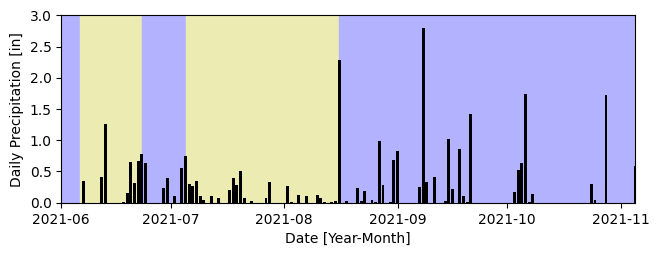

In [65]:
fig, ax = plt.subplots(1,1, figsize=(7,3))
fig.tight_layout(pad=3.0)

wet1= matplotlib.patches.Rectangle((18778,0), 6, 3, color='#b3b2fe')
dry1 = matplotlib.patches.Rectangle((18784,0), 17, 3, color='#ecebb2')
wet2= matplotlib.patches.Rectangle((18801,0), 12, 3, color='#b3b2fe')
dry2 = matplotlib.patches.Rectangle((18813,0), 42, 3, color='#ecebb2')
wet3= matplotlib.patches.Rectangle((18855,0), 82, 3, color='#b3b2fe')
ax.add_patch(wet1)
ax.add_patch(dry1)
ax.add_patch(wet2)
ax.add_patch(dry2)
ax.add_patch(wet3)
ax.bar(precip2021.Date, precip2021['precipitation'], color='k')
ax.set_xlim(left=datetime.date(2021,6,1), right=datetime.date(2021,11,5))
ax.set_ylim(bottom=0, top=3)
ax.set_ylabel("Daily Precipitation [in]")
ax.set_xlabel("Date [Year-Month]")
fig.savefig("../plots/2021_DD_Precip.JPG", dpi=300, format='jpg')
fig.savefig("../plots/2021_DD_Precip.EPS", dpi=300, format='eps')

# Plotting Timesereis of Individual Ions

In [12]:
## SPLIT THE SAMPLE SITES INTO DIFFERENT DATAFRAMES
## Subsetting WQ_DF because it cotains datetime information
wq_df = pd.read_csv("../data/Full2021_WQ_meq_L.csv", parse_dates=['Sampling time'],
                    index_col='Sampling time')
LJ=wq_df.loc[wq_df['Location'] == 'Lake Jackson']

FW=wq_df.loc[wq_df['Location'] == 'FSU Well']
WS=wq_df.loc[wq_df['Location'] == 'Wakulla Springs']
#LJ=LJ.drop('2021-05-04 13:00:00')
#FW=FW.drop('2021-05-04 12:45:00')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


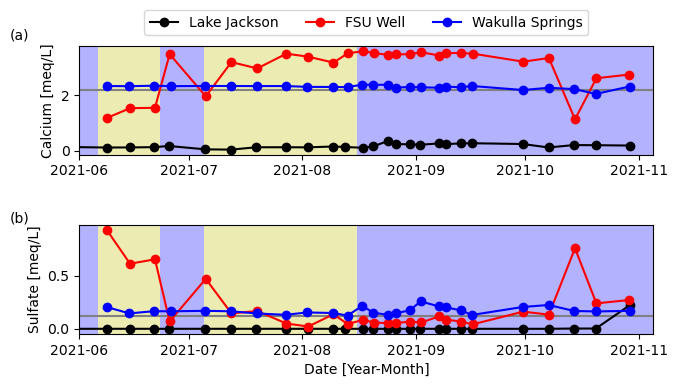

In [18]:
fig, ax = plt.subplots(2,1, figsize=(7,4))
fig.tight_layout(pad=3.0)

## Calcium Plot

ax[0].axhline(y=44/40.078*2, color= 'gray')
line1=ax[0].plot(LJ.index, LJ.Ca,'-o',color='k', label="Lake Jackson")
line2=ax[0].plot(FW.index, FW.Ca,'-o',color='r', label="FSU Well")
line3=ax[0].plot(WS.index, WS.Ca,'-o',color='b', label="Wakulla Springs")
ax[0].axvspan('2021-06-01','2021-06-06' ,facecolor='#b3b2fe')
ax[0].axvspan('2021-06-06', '2021-06-23',facecolor='#ecebb2')
ax[0].axvspan('2021-06-23', '2021-07-05',facecolor='#b3b2fe')
ax[0].axvspan('2021-07-05', '2021-08-16',facecolor='#ecebb2')
ax[0].axvspan('2021-08-16','2021-11-16' ,facecolor='#b3b2fe')
ax[0].set_xlim(left=datetime.date(2021,6,1), right=datetime.date(2021,11,5))

ax[0].set_ylabel("Calcium [meq/L]")

ax[0].legend(ncols=3,bbox_to_anchor=(0.5,1.4), loc="upper center")
ax[0].text(18760,4, "(a)")

## Sulfate Plot
ax[1].axhline(5.77/96.06*2, color='gray')
ax[1].plot(LJ.index, LJ.SO3,'-o',color='k')
ax[1].plot(FW.index, FW.SO3,'-o',color='r')
ax[1].plot(WS.index, WS.SO3,'-o',color='b')
ax[1].axvspan('2021-06-01','2021-06-06' ,facecolor='#b3b2fe')
ax[1].axvspan('2021-06-06', '2021-06-23',facecolor='#ecebb2')
ax[1].axvspan('2021-06-23', '2021-07-05',facecolor='#b3b2fe')
ax[1].axvspan('2021-07-05', '2021-08-16',facecolor='#ecebb2')
ax[1].axvspan('2021-08-16','2021-11-16' ,facecolor='#b3b2fe')
ax[1].set_xlim(left=datetime.date(2021,6,1), right=datetime.date(2021,11,5))

ax[1].set_ylabel("Sulfate [meq/L]")
ax[1].set_xlabel("Date [Year-Month]")
ax[1].text(18760,1, "(b)")
## Sulfate Plot
#ax[2].plot(LJ.index, LJ.Fluoride,'-o',color='k')ax[2].plot(FW.index, FW.Fluoride,'-o',color='r')
#ax[2].plot(WS.index, WS.Fluoride,'-o',color='b')
#ax[2].axvspan('2021-06-01','2021-06-06' ,facecolor='b', alpha=0.3)
#ax[2].axvspan('2021-06-06', '2021-06-23',facecolor='y', alpha=0.3)
#ax[2].axvspan('2021-06-23', '2021-07-05',facecolor='b', alpha=0.3)
#ax[2].axvspan('2021-07-05', '2021-08-16',facecolor='y', alpha=0.3)
#ax[2].axvspan('2021-08-16','2021-11-16' ,facecolor='b', alpha=0.3)
#ax[2].set_xlim(left=datetime.date(2021,6,1), right=datetime.date(2021,11,5))

#ax[2].set_ylabel("Fluoride [ppm]")
#ax[2].set_xlabel("Date [Year-Month]")


#ax[2].axvspan('2021-06-01','2021-06-06' ,facecolor='#b3b2fe', alpha=0.9)
#ax[2].axvspan('2021-06-06', '2021-06-23',facecolor='#ecebb2')
#ax[2].axvspan('2021-06-23', '2021-07-05',facecolor='#b3b2fe')
#ax[2].axvspan('2021-07-05', '2021-08-16',facecolor='#ecebb2')
#ax[2].axvspan('2021-08-16','2021-10-31' ,facecolor='#b3b2fe')

fig.savefig("../plots/WeeklyTimeseries.JPG", dpi=300, format='jpg')
fig.savefig("../plots/WeeklyTimeseries.EPS", dpi=300, format='eps')

In [36]:
WQChartPy_df.columns

Index(['ID', 'Sampling time', 'Location', 'pH', 'pOH', 'EC(us/cm)', 'Li', 'Na',
       'NH4', 'K', 'Mg', 'Ca', 'F', 'Cl', 'NO2', 'Br', 'NO3', 'PO4', 'SO4',
       'HCO3', 'CO3'],
      dtype='object')

Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



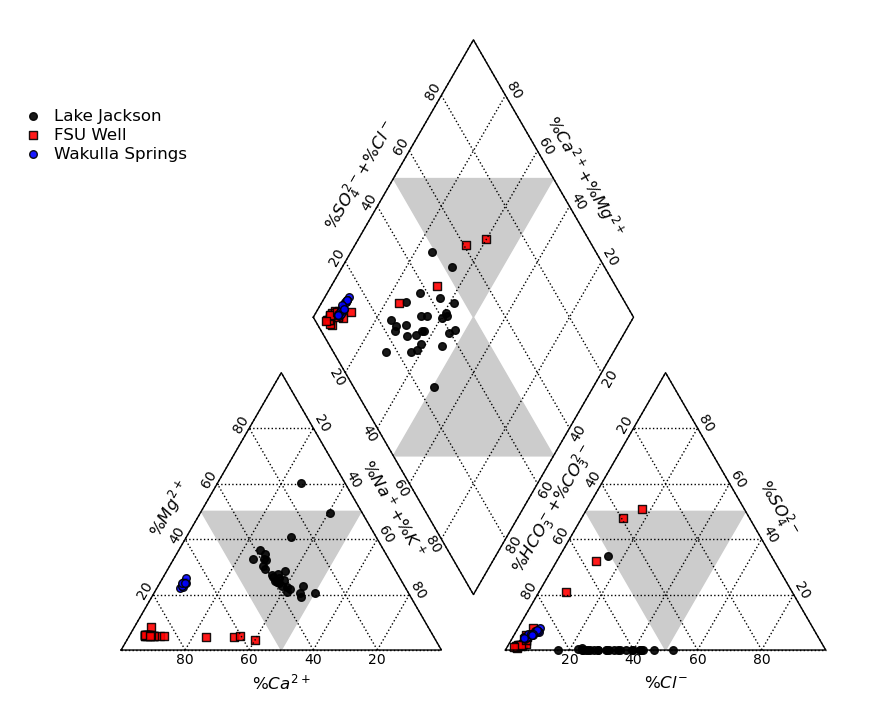

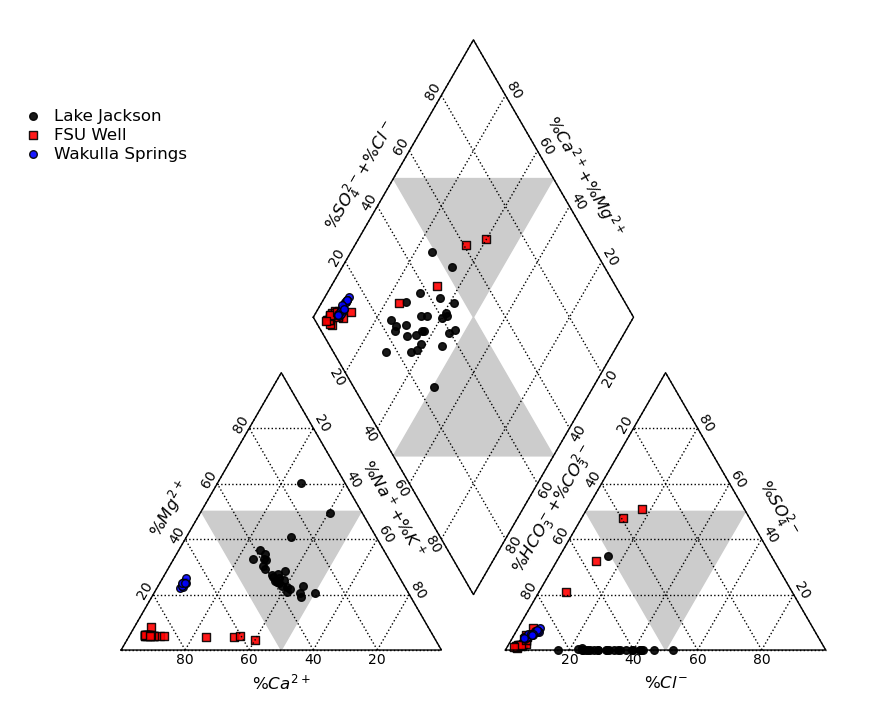

In [62]:
from wqchartpy import triangle_piper

# Draw the diagram and save it to the plots folder in both SVG and jpg formats
triangle_piper.plot(WQChartPy_df, unit='mg/L', figname='../plots/WeeklyPiper', figformat='jpg')
triangle_piper.plot(WQChartPy_df, unit='mg/L', figname='../plots/WeeklyPiper', figformat='svg')

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



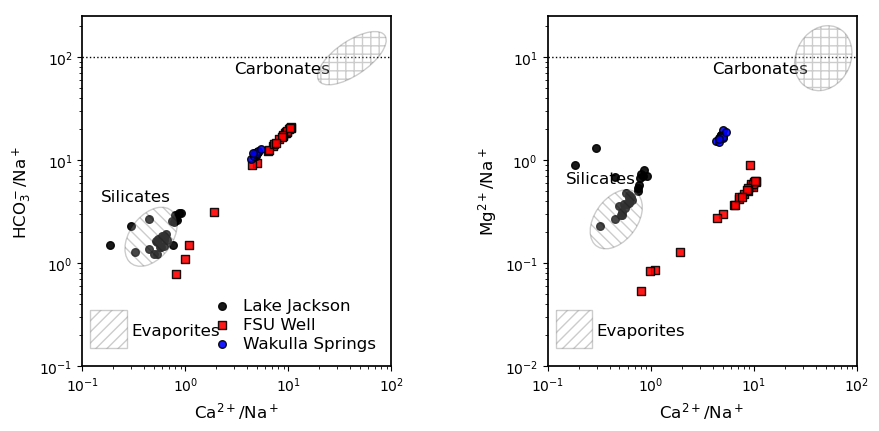

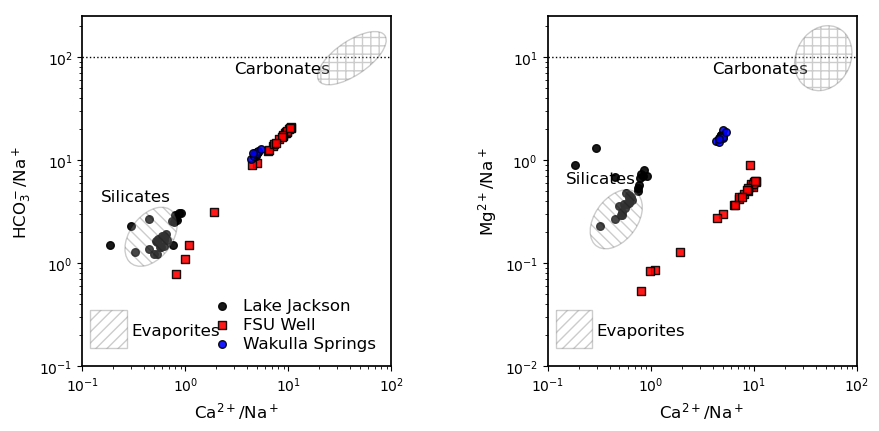

In [60]:
from wqchartpy import gaillardet; 

gaillardet.plot(WQChartPy_df, unit='mg/L', figname='../plots/WeeklyGaillardet', figformat='jpg')
gaillardet.plot(WQChartPy_df, unit='mg/L', figname='../plots/WeeklyGaillardet', figformat='svg')

## Read in the Daily scale sampling data that was collected in February 2022

In [9]:
##Daily Scale
FWD = pd.read_csv('../data/processed/FSUWell_FebMar_WQ.csv', parse_dates=['Datatime_Collection'])
FWD

,ID,Datatime_Collection,Li,Na,NH4,K,Mg,Ca,F,Cl,...,NO3,PO4,SO4,EC,TDS,pH,pOH,TotalAlk(mg/L_asCaCO3),Fe,Temp
0,FW100A,NaN,0,20.554,1.313,4.8590,2.124,30.762,1.3080,9.3182,...,8.1533,1.4925,45.2252,213.0,149.10,6.93,7.07,29.2,NaN,22.0
1,FW100B,NaN,0,19.351,1.190,4.4000,2.291,38.636,1.2288,9.0458,...,7.3998,1.4578,41.8836,232.0,162.40,7.33,6.67,46.2,NaN,22.0
2,FW100C,NaN,0,23.277,1.383,5.4860,2.216,34.128,1.3143,10.5550,...,9.6716,1.5028,52.6810,205.0,143.50,7.19,6.81,27.5,NaN,21.9
3,FW101,2/3/2022 17:20,0,19.929,1.255,5.3470,1.940,28.456,1.4120,8.7430,...,8.1602,1.2894,44.4687,201.0,140.70,6.83,7.17,23.6,0.220,20.5
4,FW102,2/4/2022 10:45,0,20.288,1.197,5.1000,2.117,32.874,1.5083,9.1747,...,8.1795,1.5216,44.7318,211.0,147.70,7.13,6.87,30.1,0.090,19.7
5,FW103,2/5/2022 12:10,0,17.335,0.894,4.1830,2.651,49.071,1.2057,9.1106,...,6.2254,1.2443,33.5713,252.0,176.40,8.21,5.79,67.5,0.087,20.7
6,FW104,2/6/2022 18:40,0,11.149,0.454,2.4660,3.369,66.684,0.6093,6.7956,...,3.9636,0.8244,19.0000,294.0,205.80,7.72,6.28,115.2,0.330,21.9
7,FW105,2/7/2022 13:40,0,7.909,0.209,1.4090,4.350,90.422,0.3530,6.1536,...,2.3276,0.5909,8.9506,298.0,208.60,7.64,6.36,135.8,0.000,21.3
8,FW106,2/8/2022 11:40,0,6.577,0.103,1.8280,4.240,85.823,0.3840,5.5829,...,1.5865,0.4624,4.7882,319.0,223.30,7.62,6.38,152.2,0.000,21.1
9,FW107,2/9/2022 16:00,0,6.049,0.156,0.1325,3.903,77.680,0.3223,5.2780,...,1.6294,0.4524,5.2684,308.0,215.60,7.71,6.29,143.8,0.163,21.9


In [10]:
###Accurate Bicarbonate Calculation OLM Package and USGS procedure
## ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
from olm.calcite import calc_K_2

def alk_mgLCaCo3_to_meqL(alk_mgL):
    alk_meqL=alk_mgL/(1/2)/(100.087)
    return alk_meqL

## Second dissociation constant needed for speciation
K2=calc_K_2(298.15)

# ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
FWD['H']=(10**-FWD['pH'])*1.00784*1000
FWD["OH"]=(1E-14*(10**FWD["pH"])*17007.3)
FWD["CO3"]=(((alk_mgLCaCo3_to_meqL(FWD["TotalAlk(mg/L_asCaCO3)"])/1000)-(FWD['OH']/17007.3)+10**-FWD['pH'])/(2+(10**-FWD['pH']/K2)))*60009.2

FWD["HCO3"]=(((alk_mgLCaCo3_to_meqL(FWD["TotalAlk(mg/L_asCaCO3)"])/1000)-(FWD['OH']/17007.3)+10**-FWD['pH'])/(1+(2*K2*10**FWD['pH'])))*61017.1

In [11]:
format_df2 = pd.DataFrame()

format_df2['Sample'] = FWD['ID']
format_df2['Label'] = 'Daily FSU Well'
format_df2['Color']='r'
format_df2['Marker']='s'
format_df2['Size']=30
format_df2['Alpha']=0.9
format_df2['pH'] = FWD['pH']
format_df2['Ca'] = FWD['Ca']
format_df2['Mg'] = FWD['Mg']
format_df2['Na'] = FWD['Na']              
format_df2['K'] = FWD['K']   
format_df2['HCO3'] = FWD['HCO3']
format_df2['Cl'] = FWD['Cl']
format_df2['CO3']= FWD['CO3']
format_df2['SO4'] = FWD['SO4'].values
format_df2['TDS'] = FWD['EC']*0.7
#format_df['Day']= wq_df['Sampling time'].dt.dayofyear-124
format_df2
format_df2.drop(format_df2.tail(3).index,inplace=True) # drop last n rows


Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



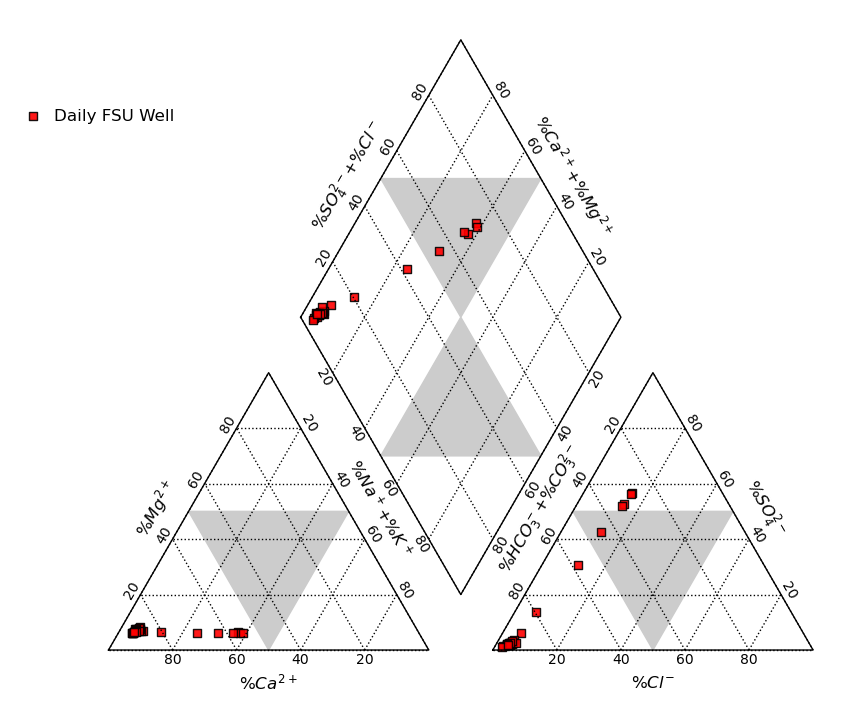

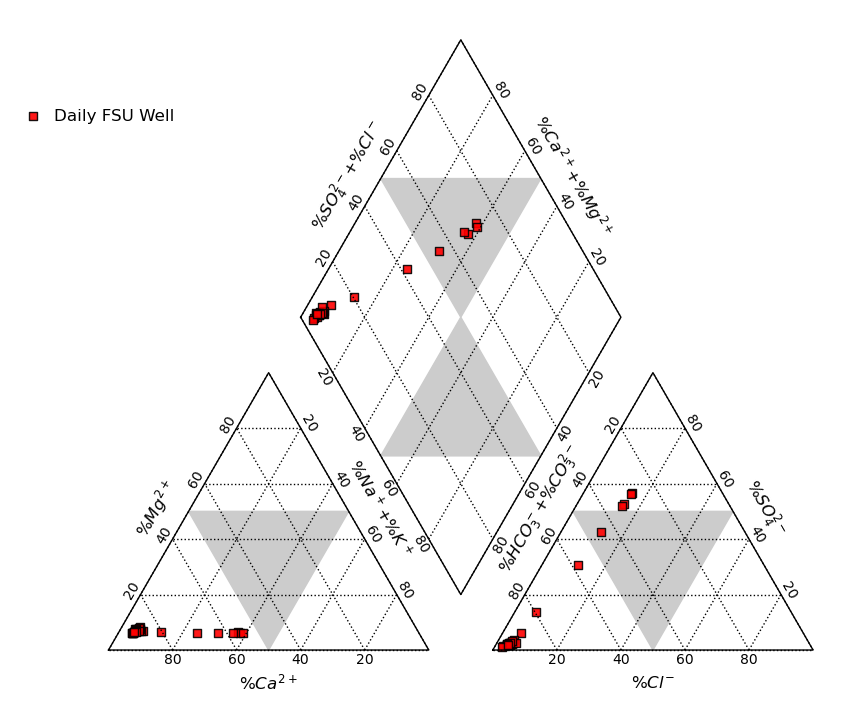

In [12]:
from wqchartpy import triangle_piper

# Draw the diagram
triangle_piper.plot(format_df2, unit='mg/L', figname='../plots/PiperDaily', figformat='jpg')
triangle_piper.plot(format_df2, unit='mg/L', figname='../plots/PiperDaily', figformat='SVG')

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



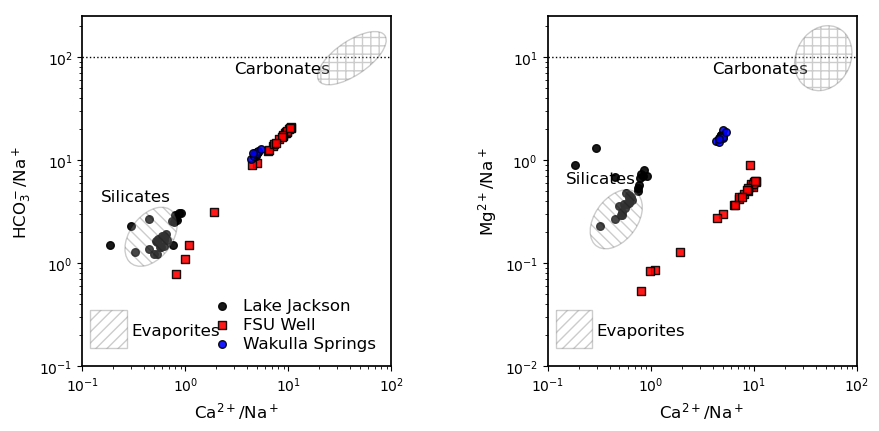

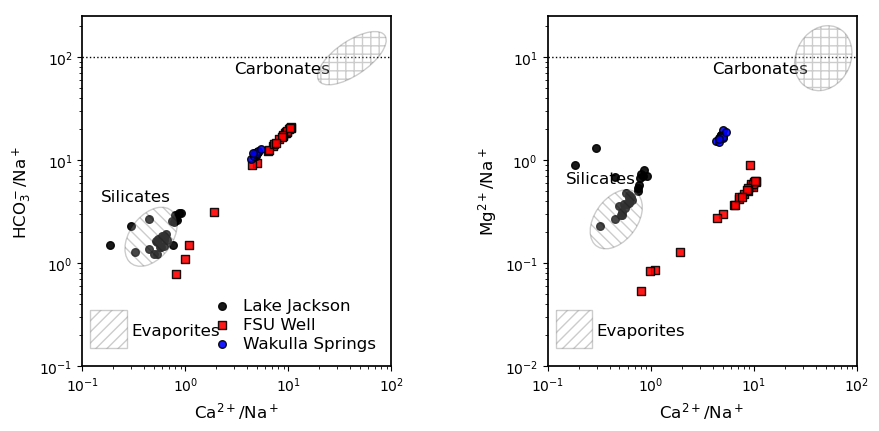

In [31]:
from wqchartpy import gaillardet;
gaillardet.plot(format_df, unit='mg/L', figname='../plots/GaillardetDaily', figformat='svg')
gaillardet.plot(format_df, unit='mg/L', figname='../plots/GaillardetDaily', figformat='jpg')

In [12]:
feb_df=FWD.iloc[3:28]
feb_df

,ID,Datatime_Collection,Li,Na,NH4,K,Mg,Ca,F,Cl,...,TDS,pH,pOH,TotalAlk(mg/L_asCaCO3),Fe,Temp,H,OH,CO3,HCO3
3,FW101,2/3/2022 17:20,0,19.929,1.255,5.3470,1.940,28.456,1.4120,8.7430,...,140.7,6.83,7.17,23.6,0.220,20.5,0.000149,0.001150,0.008969,28.761698
4,FW102,2/4/2022 10:45,0,20.288,1.197,5.1000,2.117,32.874,1.5083,9.1747,...,147.7,7.13,6.87,30.1,0.090,19.7,0.000075,0.002294,0.022803,36.650285
5,FW103,2/5/2022 12:10,0,17.335,0.894,4.1830,2.651,49.071,1.2057,9.1106,...,176.4,8.21,5.79,67.5,0.087,20.7,0.000006,0.027583,0.605679,80.971197
6,FW104,2/6/2022 18:40,0,11.149,0.454,2.4660,3.369,66.684,0.6093,6.7956,...,205.8,7.72,6.28,115.2,0.330,21.9,0.000019,0.008926,0.338252,139.742471
7,FW105,2/7/2022 13:40,0,7.909,0.209,1.4090,4.350,90.422,0.3530,6.1536,...,208.6,7.64,6.36,135.8,0.000,21.3,0.000023,0.007424,0.331952,164.878099
8,FW106,2/8/2022 11:40,0,6.577,0.103,1.8280,4.240,85.823,0.3840,5.5829,...,223.3,7.62,6.38,152.2,0.000,21.1,0.000024,0.007090,0.355369,184.827955
9,FW107,2/9/2022 16:00,0,6.049,0.156,0.1325,3.903,77.680,0.3223,5.2780,...,215.6,7.71,6.29,143.8,0.163,21.9,0.000020,0.008722,0.412682,174.463309
10,FW108,2/10/2022 11:20,0,5.850,0.000,0.8390,4.250,85.525,0.2146,5.3396,...,222.6,7.69,6.31,151.8,0.130,21.8,0.000021,0.008330,0.416131,184.212011
11,FW109,2/11/2022 10:45,0,5.325,0.000,0.8250,4.116,83.670,0.1803,4.9430,...,228.2,7.66,6.34,155.0,0.117,21.9,0.000022,0.007774,0.396669,188.155371
12,FW110,2/12/2022 15:20,0,6.262,0.000,1.0800,4.677,100.452,0.2068,5.7119,...,236.6,7.58,6.42,164.2,0.080,21.8,0.000027,0.006466,0.349781,199.473072


In [2]:

feb_df = pd.read_csv("../data/FSU_Well_FEB_meq_L.csv")
feb_df=feb_df[3:]
feb_df["Datatime_Collection"]=pd.to_datetime(feb_df["Datatime_Collection"])
feb_df

,ID,Datatime_Collection,Li,Na,NH4,K,Mg,Ca,F,Cl,...,SO4,CO3,HCO3,EC,TDS,pH,pOH,Cations,Anions,Charge Balance
3,FW101,2022-02-03 17:20:00,0,0.870262,0.069571,0.136759,0.159638,1.420031,0.074324,0.246629,...,0.925853,0.000298952,0.47,201,140.7,6.83,7.17,2.656261,1.893573625,16.7629743
4,FW102,2022-02-04 10:45:00,0,0.885939,0.066356,0.130441,0.174203,1.640501,0.079393,0.258807,...,0.931330,0.000760062,0.60,211,147.7,7.13,6.87,2.897440,2.054111141,17.03161645
5,FW103,2022-02-05 12:10:00,0,0.756987,0.049559,0.106988,0.218144,2.448775,0.063465,0.256999,...,0.698965,0.020188291,1.33,252,176.4,8.21,5.79,3.580453,2.509082777,17.59362803
6,FW104,2022-02-06 18:40:00,0,0.486856,0.025168,0.063072,0.277227,3.327711,0.032072,0.191695,...,0.395586,0.011274503,2.29,294,205.8,7.72,6.28,4.180034,3.011992768,16.24077678
7,FW105,2022-02-07 13:40:00,0,0.345371,0.011586,0.036038,0.357951,4.512301,0.018581,0.173585,...,0.186354,0.011064513,2.70,298,208.6,7.64,6.36,5.263247,3.148645258,25.13823992
8,FW106,2022-02-08 11:40:00,0,0.287205,0.005710,0.046754,0.348899,4.282799,0.020213,0.157487,...,0.099692,0.011845041,3.03,319,223.3,7.62,6.38,4.971367,3.35922899,19.35201626
9,FW107,2022-02-09 16:00:00,0,0.264148,0.008648,0.003389,0.321168,3.876441,0.016965,0.148886,...,0.109690,0.013755379,2.86,308,215.6,7.71,6.29,4.473795,3.189714146,16.75577881
10,FW108,2022-02-10 11:20:00,0,0.255459,0.000000,0.021459,0.349722,4.267928,0.011296,0.150623,...,0.076065,0.01387034,3.02,318,222.6,7.69,6.31,4.894567,3.308760682,19.33125883
11,FW109,2022-02-11 10:45:00,0,0.232533,0.000000,0.021101,0.338696,4.175358,0.009490,0.139436,...,0.073456,0.013221639,3.08,326,228.2,7.66,6.34,4.767687,3.354818289,17.39449793
12,FW110,2022-02-12 15:20:00,0,0.273450,0.000000,0.027623,0.384859,5.012825,0.010885,0.161126,...,0.087741,0.011658784,3.27,338,236.6,7.58,6.42,5.698757,3.583191016,22.79226073


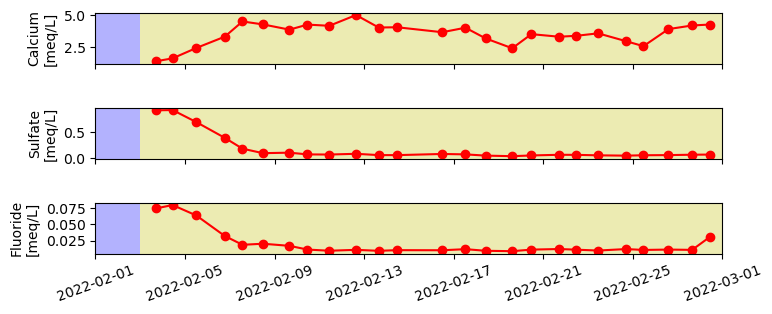

In [24]:

### PLOT TIMESERIES OF INDIVIDUAL IONS AT DAILY SCALE

fig, ax = plt.subplots(3,1, figsize=(7,3))
fig.tight_layout()

## Calcium Plot
ax[0].plot(feb_df.Datatime_Collection, feb_df.Ca,'-o',color='r')
ax[0].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[0].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[0].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))

ax[0].set_ylabel("Calcium\n[meq/L]")
ax[0].set_xticklabels([])

ax[1].plot(feb_df.Datatime_Collection, feb_df.SO4,'-o',color='r')
ax[1].tick_params(axis='x', labelrotation=20)
ax[1].set_ylabel("Sulfate\n[meq/L]")
ax[1].set_xticklabels([])
ax[1].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[1].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[1].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))

ax[2].plot(feb_df.Datatime_Collection, feb_df.F,'-o',color='r')

ax[2].set_ylabel("Fluoride\n[meq/L]")
ax[2].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[2].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[2].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[2].tick_params(axis='x', labelrotation=20)
#ax[2].set_xlabel("Date [Year-Month]")
#fig.savefig("../plots/DailyTimeseries.JPG", dpi=300, format='jpg',bbox_inches="tight")
#fig.savefig("../plots/DailyTimeseries.EPS", dpi=300, format='eps',bbox_inches="tight")

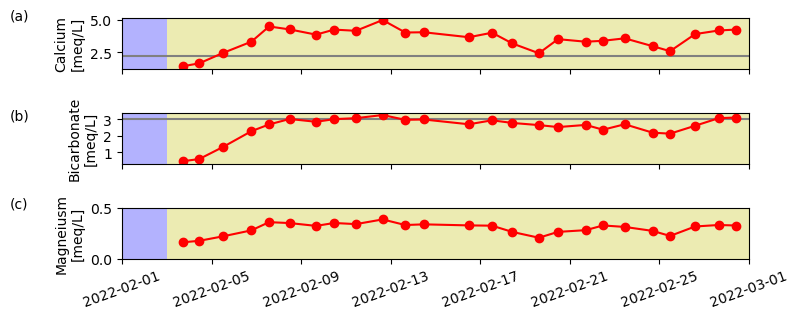

In [3]:
### CARBONATE SYSTEM IONS
### PLOT TIMESERIES OF INDIVIDUAL IONS AT DAILY SCALE
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(3,1, figsize=(7,3))
fig.tight_layout()

## Calcium Plot
ax[0].axhline(y=44/40.078*2, color= 'gray')

ax[0].plot(feb_df.Datatime_Collection, feb_df.Ca,'-o',color='r')
ax[0].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[0].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[0].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))

ax[0].set_ylabel("Calcium\n[meq/L]")
ax[0].set_xticklabels([])
ax[0].text(19019,5, "(a)")

## Bicarbonate Plot
ax[1].axhline(183.7/61.0168, color='gray')
#ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1].plot(feb_df['Datatime_Collection'], np.asarray(feb_df['HCO3'], float),'-o',color='r')
ax[1].tick_params(axis='x', labelrotation=20)
ax[1].set_xticklabels([])
ax[1].set_ylabel("Bicarbonate\n[meq/L]")
#ax[1].set_xticklabels([])
#ax[1].set_yticks([0, 30])

ax[1].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[1].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[1].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[1].text(19019,3, "(b)")
## MAgnsiumn Plot
ax[2].plot(feb_df.Datatime_Collection, feb_df.Mg,'-o',color='r')
ax[2].set_ylabel("Magneiusm\n[meq/L]")
ax[2].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[2].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[2].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[2].set_ylim(0,0.5)
ax[2].axhline(13/24.305*2, color='gray')
ax[2].tick_params(axis='x', labelrotation=20)
ax[2].text(19019,0.5, "(c)")
fig.savefig("../plots/DailyCarbonateTimeseries.JPG", dpi=300, format='jpg',bbox_inches="tight")
fig.savefig("../plots/DailyCarbonateTimeseries.EPS", dpi=300, format='eps',bbox_inches="tight")

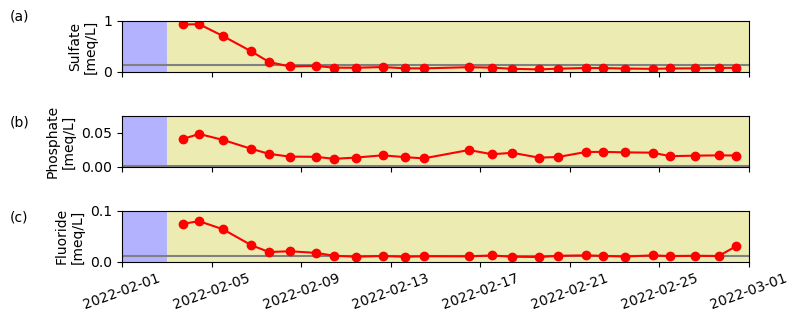

In [39]:
## HAWTHORN GROUP MINERALS

### PLOT TIMESERIES OF INDIVIDUAL IONS AT DAILY SCALE

fig, ax = plt.subplots(3,1, figsize=(7,3))
fig.tight_layout()

## Sulfate Plot
ax[0].axhline(5.77/96.06*2, color='gray')
ax[0].plot(feb_df.Datatime_Collection, feb_df.SO4,'-o',color='r')
ax[0].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[0].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[0].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[0].set_ylabel("Sulfate\n[meq/L]")
ax[0].set_ylim(0,1)
ax[0].set_xticklabels([])
ax[0].text(19019,1, "(a)")

ax[1].axhline(0.027/94.9714*3, color='gray')
ax[1].plot(feb_df.Datatime_Collection, feb_df.PO4,'-o',color='r')
ax[1].tick_params(axis='x', labelrotation=20)
ax[1].set_ylabel("Phosphate\n[meq/L]")
ax[1].set_xticklabels([])

ax[1].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[1].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[1].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[1].set_ylim(0,0.075)
ax[1].text(19019,0.06, "(b)")

ax[2].axhline(0.2/18.998, color='gray')
ax[2].plot(feb_df.Datatime_Collection, feb_df.F,'-o',color='r')

ax[2].set_ylabel("Fluoride\n[meq/L]")
ax[2].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[2].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[2].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[2].set_ylim(0,0.1)
ax[2].tick_params(axis='x', labelrotation=20)
ax[2].text(19019,0.08, "(c)")
fig.savefig("../plots/DailySilicateTimeseries.JPG", dpi=300, format='jpg',bbox_inches="tight")
fig.savefig("../plots/DailySilicateTimeseries.EPS", dpi=300, format='eps',bbox_inches="tight")

In [ ]:
## HAWTHORN GROUP MINERALS

### PLOT TIMESERIES OF INDIVIDUAL IONS AT DAILY SCALE

fig, ax = plt.subplots(2,1, figsize=(7,3))
fig.tight_layout()

## Potassium Plot
ax[0].axhline(0.367/39.098, color='gray')
ax[0].plot(feb_df.Datatime_Collection, feb_df.K,'-o',color='r')
ax[0].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[0].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[0].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[0].set_ylabel("Potassium\n[meq/L]")
ax[0].set_xticklabels([])
ax[0].text(19019,0.3, "(a)")


# Sodium Plot
ax[1].axhline(2.7/22.990, color='gray')
ax[1].plot(feb_df.Datatime_Collection, feb_df.Na,'-o',color='r')

ax[1].set_ylabel("Sodium\n[meq/L]")
ax[1].axvspan('2022-01-30','2022-02-03' ,facecolor='#b3b2fe')
ax[1].axvspan('2022-02-03', '2022-03-02',facecolor='#ecebb2')
ax[1].set_xlim(left=datetime.date(2022,2,1), right=datetime.date(2022,3,1))
ax[1].set_ylim(0,)
ax[1].tick_params(axis='x', labelrotation=20)
ax[1].text(19019,1.2, "(b)")
fig.savefig("../plots/DailyKNaTimeseries.JPG", dpi=300, format='jpg',bbox_inches="tight")
fig.savefig("../plots/DailyKNaTimeseries.EPS", dpi=300, format='eps',bbox_inches="tight")